In [4]:
import glob
import rasterio
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


torch.manual_seed(666)

def get_chip(path):
    return path.split('/')[-1].replace('.tif', '')


class CloudDataset(Dataset):
    def __init__(self, root_dir, sub_dir):
        self.data_dir = f'{root_dir}/{sub_dir}'
                        
        image_paths = glob.glob(f'{self.data_dir}/source/*.tif')        
        label_paths = glob.glob(f'{self.data_dir}/labels/*.tif')
        
        image_paths = sorted(image_paths, key=lambda x: x.split('/')[-1])
        label_paths = sorted(label_paths, key=lambda x: x.split('/')[-1])
        
        assert len(image_paths) == len(label_paths)

        self.image_paths = image_paths
        self.label_paths = label_paths
        
        print(f'{sub_dir}... {len(self.image_paths)} chips')
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
                
        image_path = self.image_paths[index]
        label_path = self.label_paths[index]
        
        with rasterio.open(image_path) as src:
            image = src.read()
            image = torch.from_numpy(image)

        with rasterio.open(label_path) as src:
            label = src.read(1)
            label = torch.from_numpy(label).long()     
            
        return image, label

cloud_training_dir = "./data/mergedCloudTrainingData/split"

train_dataset = CloudDataset(root_dir=cloud_training_dir, sub_dir='train')
train_dataloader = DataLoader(train_dataset, batch_size=8, num_workers=0, shuffle=True)

val_dataset = CloudDataset(root_dir=cloud_training_dir, sub_dir='val')
val_dataloader = DataLoader(val_dataset, batch_size=8, num_workers=0, shuffle=True)

test_dataset = CloudDataset(root_dir=cloud_training_dir, sub_dir='test')
test_dataloader = DataLoader(test_dataset, batch_size=8, num_workers=0, shuffle=True)


train... 1500 chips
val... 187 chips
test... 189 chips


## Setup model and loss

In [5]:

ACTIVATION = None
ENCODER = 'resnet18' 
LOSS = 'dice'

model = smp.UnetPlusPlus(
    encoder_name=ENCODER,
    encoder_depth=5, 
    encoder_weights='imagenet', 
    decoder_use_batchnorm=True, 
    decoder_channels=(256, 128, 64, 32, 16), 
    decoder_attention_type=None,
    in_channels=4,
    classes=1,
    activation=ACTIVATION
)


if LOSS == 'dice':
    loss = smp.losses.DiceLoss(mode="binary")
    loss.__name__ = 'Dice_loss'
else:
    raise ValueError("loss not implemented")

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001) # 0.1


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Set up epochs and run training

In [ ]:
model_path =  f'./best_{ENCODER}_{LOSS}_cloud_detection_model.pth'

In [7]:

metrics = []

train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss,
    metrics= metrics,
    optimizer=optimizer,
    verbose=True,
)

val_epoch = smp_utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    verbose=True,
)


NUM_EPOCHS = 2

for i in range(0, NUM_EPOCHS):
    train_logs = train_epoch.run(train_dataloader)
    val_logs = val_epoch.run(val_dataloader)
    torch.save(model, model_path)
    
print('done')

valid: 100%|██████████| 24/24 [01:01<00:00,  2.56s/it, Dice_loss - 0.09369]
done


## Visualize model outputs

./data/mergedCloudTrainingData/split/test/source/S2A_35MQU_20220221_0_L2A_1_7.tif
./data/mergedCloudTrainingData/split/test/source/S2A_35MQV_20210825_0_L2A_0_4_180deg.tif
./data/mergedCloudTrainingData/split/test/source/S2A_35MQV_20211123_0_L2A_0_2.tif


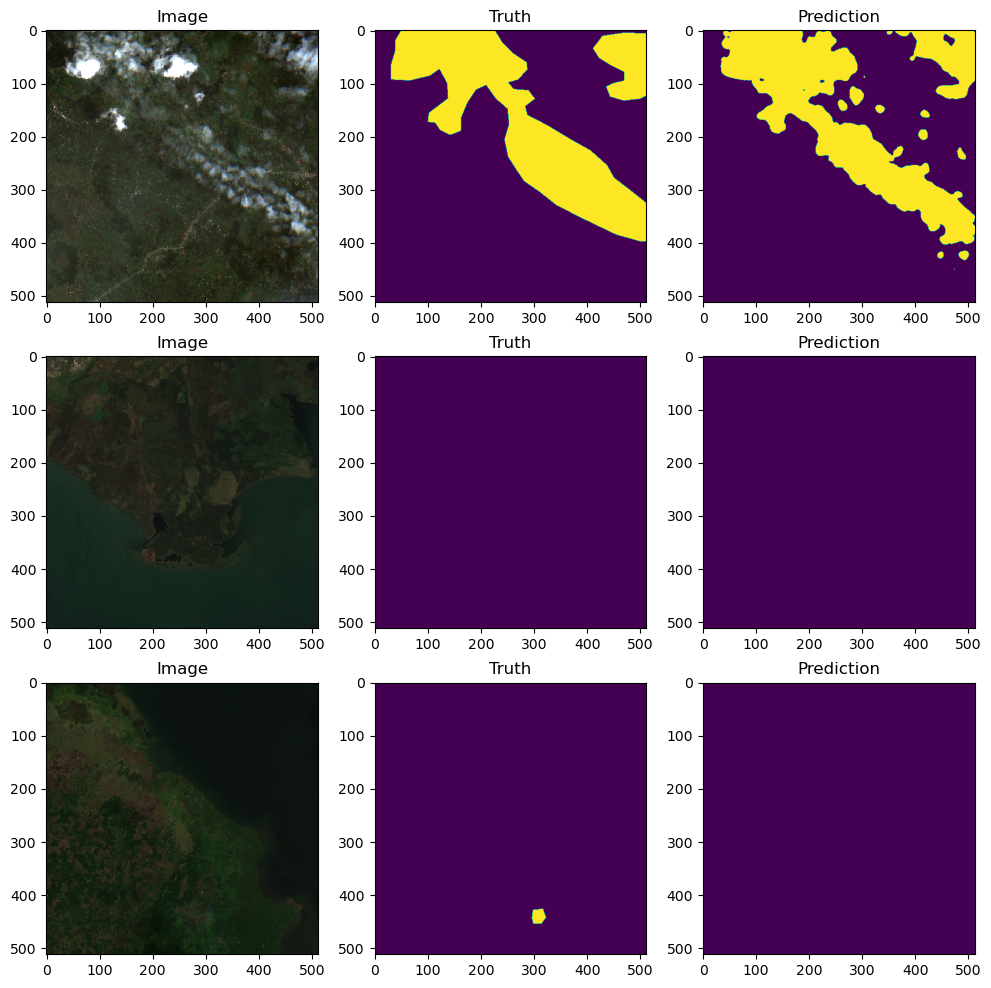

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from common.utilities.visualization import plot_bands


count = 3
offset = 0

fig, rows = plt.subplots(count, 3, figsize=(12, 12))
if rows.ndim == 1:
    rows = np.expand_dims(rows, 0)

    
best_model = torch.load(model_path)

for i in range(count):
                    
    row = rows[i]    
    image, labels = test_dataset[i+offset]    
    image_path = test_dataset.image_paths[i+offset]
    print(image_path)
        
    image = np.expand_dims(image, 0) 
    image = torch.tensor(image)
    
    prediction = best_model.predict(image)       
    probabilities = torch.sigmoid(prediction).cpu().numpy()
    probabilities = probabilities[0, 0, :, :]
    binary_prediction = (probabilities >= 0.80).astype(bool)
        
    labels = labels.squeeze().numpy()
    labels = np.ma.array(labels, mask=(labels==2))

    image = image.cpu().numpy().squeeze(0)
    plot_bands(image, bands=[2, 1, 0], ax=row[0], transpose=True)
    row[0].set_title('Image')
    
    row[1].imshow(labels, vmin=0, vmax=1)
    row[1].set_title('Truth')
    
    row[2].imshow(binary_prediction, vmin=0, vmax=1)
    row[2].set_title('Prediction')
    